### Overview of the patent owners for each target

#### Import modules

In [1]:
import pandas as pd
from tqdm import tqdm
from collections import defaultdict

import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
mpl.rcParams['figure.dpi'] = 400

### Loading data files

In [4]:
DATA_DIR = '../data/patent_dumps'
FIG_DIR = '../data/figures'

In [5]:
rare_disease_data = pd.read_csv(f'{DATA_DIR}/orphanet_gene_enumerated_patent_data.tsv', sep='\t')
rare_disease_data.head(2)

,chembl,surechembl,patent_id,date,ipc,assignee,organization_name,acquired_by,person,genes
0,CHEMBL3137316,SCHEMBL1707427,US-20140316139-A1,2014-10-23,C07D 213/89,PFIZER,Pfizer,NaN,NaN,"IL6, NR3C1"
1,CHEMBL3137316,SCHEMBL1707427,US-20140142316-A1,2014-05-22,C07D 213/89,PFIZER,Pfizer,NaN,NaN,"IL6, NR3C1"


In [6]:
alzheimer_disease_data = pd.read_csv(f'{DATA_DIR}/ad_gene_enumerated_patent_data.tsv', sep='\t')
alzheimer_disease_data.head(2)

,chembl,surechembl,patent_id,date,ipc,assignee,organization_name,acquired_by,person,genes
0,CHEMBL1460470,SCHEMBL14919618,US-20140256767-A1,2014-09-11,C07D 401/14,UNIV RUTGERS,Rutgers University,NaN,NaN,"DUSP3, PTPN7, POLB"
1,CHEMBL1460470,SCHEMBL14919618,US-20180148408-A1,2018-05-31,C07D 209/48,UNIV RUTGERS,Rutgers University,NaN,NaN,"DUSP3, PTPN7, POLB"


Drop patents with no assignee names

In [7]:
rare_disease_data.shape, alzheimer_disease_data.shape

((17506, 10), (76321, 10))

In [8]:
rare_disease_data = rare_disease_data[~rare_disease_data['assignee'].isna()]
rare_disease_data.shape

(17375, 10)

In [9]:
alzheimer_disease_data = alzheimer_disease_data[~alzheimer_disease_data['assignee'].isna()]
alzheimer_disease_data.shape

(75616, 10)

### Historic perspective of top 10 assignees

Patent document based assignee ranking 

In [10]:
def create_assignee_rank(df: pd.DataFrame):
    """Create assignee dataframe based on the no.of patent documents contributed."""
    
    assignee_dict = defaultdict(set)
    patent_dict = defaultdict(lambda: defaultdict(set))
    
    for patent_idx, date, assignee, org, is_aquired, person_name in tqdm(
        df[['patent_id', 'date', 'assignee', 'organization_name', 'acquired_by', 'person']].values
    ):
        year = date.split("-")[0]
        
        if pd.notna(is_aquired):
            assignee_dict['acquired'].add(is_aquired)
            patent_dict[is_aquired][year].add(patent_idx)
        elif pd.notna(person_name):
            assignee_dict['individuals'].add(assignee)
            patent_dict[assignee][year].add(patent_idx)
        else:
            assert pd.notna(org), f"Some discepancy found in {patent_idx}!"
            assignee_dict['organisation'].add(org)
            patent_dict[org][year].add(patent_idx)
        
    patent_data = []
    for assignee_name, year_based_dict in patent_dict.items():        
        # Get total patent count
        all_patents = set()
        for patents in year_based_dict.values():
            all_patents.update(patents)
        
        for year, year_patents in year_based_dict.items():
            patent_data.append({
                'assignee_name': assignee_name,
                'total_patent_count': len(all_patents),
            })
        
    return pd.DataFrame(patent_data)

In [11]:
rare_disease_assignee_rank = create_assignee_rank(rare_disease_data)
rare_disease_assignee_rank.sort_values(by=['total_patent_count'], ascending=False, inplace=True)

# Get top 10 assignees and sort by year
top_10_rare_disease_assignee = rare_disease_assignee_rank[
    'assignee_name'
].value_counts().head(10).index.to_list()

top_10_rare_disease_assignee

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17375/17375 [00:00<00:00, 265473.88it/s]


['Pfizer',
 'Sanofi',
 'Ipsen',
 'Johnson and Johnson',
 'Takeda Pharmaceutical Company',
 'GlaxoSmithKline',
 'Ardelyx',
 'Sage Therapeutics',
 'Cleave Therapeutics',
 'Reset Therapeutics']

In [12]:
alzheimers_disease_assignee_rank = create_assignee_rank(alzheimer_disease_data)
alzheimers_disease_assignee_rank.sort_values(by='total_patent_count', ascending=False, inplace=True)

# Get top 10 assignees and sort by year
top_10_alzheimer_disease_assignee = alzheimers_disease_assignee_rank[
    'assignee_name'
].value_counts().head(10).index.to_list()
top_10_alzheimer_disease_assignee

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75616/75616 [00:00<00:00, 267783.84it/s]


['Pfizer',
 'Johnson and Johnson',
 'Amgen Inc.',
 'Bayer',
 'Takeda Pharmaceutical Company',
 'Bristol Myers Squibb',
 'Merck',
 'Novartis',
 'Roche',
 'AstraZeneca']

### Filtering basic data with top 10 inventors

In [13]:
top_rare_disease_inventors = rare_disease_data[
    rare_disease_data['organization_name'].isin(top_10_rare_disease_assignee)
]
top_rare_disease_inventors.shape

(2839, 10)

In [14]:
top_alzheimer_disease_inventors = alzheimer_disease_data[
    alzheimer_disease_data['organization_name'].isin(top_10_alzheimer_disease_assignee)
]
top_alzheimer_disease_inventors.shape

(19620, 10)

### Creating target wise matrix

In [15]:
def get_target_matrix(df: pd.DataFrame, cutoff:int = 2):
    """Creating matrix of targets patented by inventors."""
    
    data = pd.DataFrame()
    
    for assignee_name in tqdm(df['organization_name'].unique()):
        tmp_df = df[df['organization_name'] == assignee_name]
        target_dict = defaultdict(int)
        
        if assignee_name == 'Takeda Pharmaceutical Company':
            assignee_name = 'Takeda'
        elif assignee_name == 'Bristol Myers Squibb':
            assignee_name = 'BMS'
        
        target_dict['Inventor'] = assignee_name
        
        for genes in tmp_df['genes']:
            for gene in genes.split(', '):
                target_dict[gene] += 1
        
        
        targ_df = pd.DataFrame([target_dict])
        data = pd.concat([data, targ_df], ignore_index=True)
        
    data.fillna(0, inplace=True)
    data.set_index('Inventor', inplace=True)
    
    # Drop things below 10 patents
    k = data.sum(axis=0) > 10
    k = k[k]
    data = data[k.index]
    
    # Keep columns with targets patented by 2 or more inventors
    cols_to_keep = []
    for column in data.columns:
        val_dict = data[column].value_counts().to_dict()
        if len(val_dict) >= cutoff:
            cols_to_keep.append(column)

    data = data[cols_to_keep]
    return data

In [16]:
rare_disease_portfolio = get_target_matrix(top_rare_disease_inventors, cutoff=2)
rare_disease_portfolio.head(2)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 312.10it/s]


,IL6,NR3C1,PYGL,STS,DAO,NOD2,SLC9A3,PYGM,GABRD,PER2,VCP
Inventor,,,,,,,,,,,
Pfizer,21.0,21.0,11.0,440.0,417.0,0.0,0.0,0.0,0.0,0.0,0.0
GlaxoSmithKline,0.0,0.0,128.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0


In [17]:
alzheimer_disease_portfolio = get_target_matrix(top_alzheimer_disease_inventors, cutoff=3)
alzheimer_disease_portfolio.head(2)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 31.56it/s]


,KRAS,DYRK1A,HIPK2,DAPK3,HIPK4,TTK,LRRK2,ROCK2,TAOK3,TAOK1,...,PSMB10,PSMA3,PSMB2,PSMB11,PSMA2,PSMB4,PSMB8,PSMA8,PSMB6,PSMB1
Inventor,,,,,,,,,,,,,,,,,,,,,
Roche,1.0,7.0,1.0,1.0,1.0,6.0,141.0,10.0,6.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Merck,0.0,1.0,0.0,0.0,0.0,0.0,28.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# Keep only top 30 targets
top_30_patented_targets = alzheimer_disease_portfolio.sum(axis=0).sort_values(ascending=False).head(30)

alzheimer_disease_portfolio = alzheimer_disease_portfolio[
    alzheimer_disease_portfolio.columns[
        alzheimer_disease_portfolio.columns.isin(top_30_patented_targets.index)
    ]
]

alzheimer_disease_portfolio.head(2)

,TTK,LRRK2,ROCK2,CYP11B2,CYP11B1,F10,MAP4K4,DGAT1,CYP2D6,HRH1,...,F11,IGF1R,SCD,INSR,PTK2B,LIPG,SMO,LPAR5,KHK,GCG
Inventor,,,,,,,,,,,,,,,,,,,,,
Roche,6.0,141.0,10.0,364.0,227.0,76.0,56.0,11.0,96.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Merck,0.0,28.0,0.0,88.0,64.0,32.0,2.0,2.0,10.0,10.0,...,1.0,1.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Visualisation

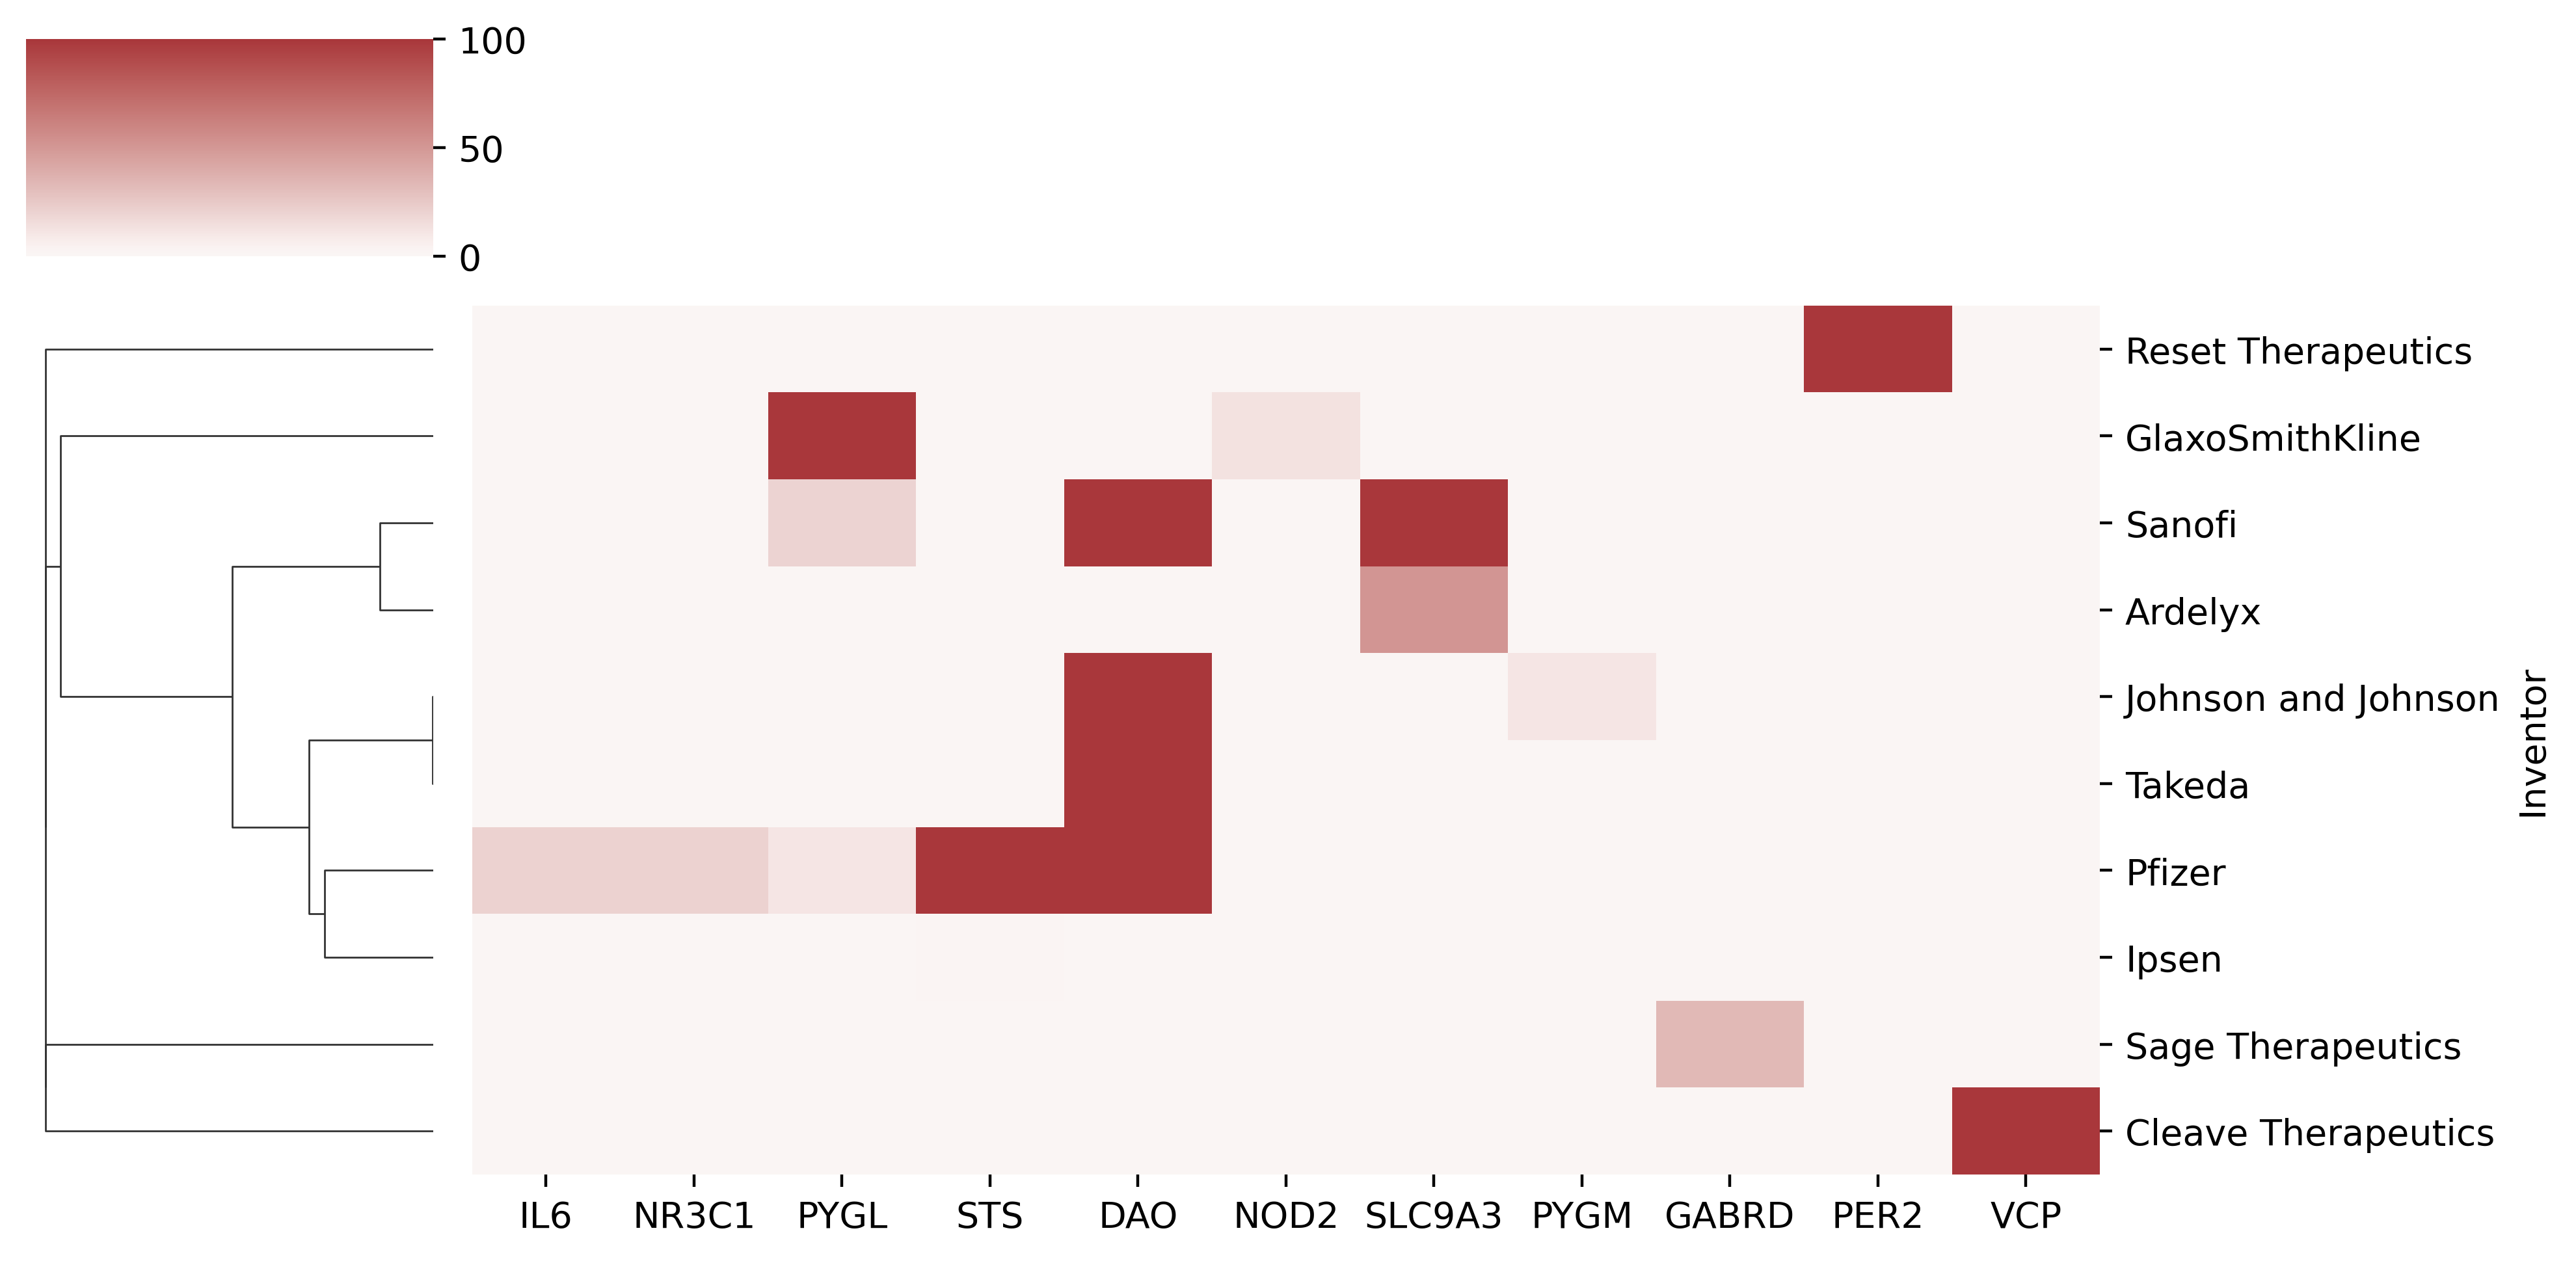

In [19]:
ax = sns.clustermap(
    rare_disease_portfolio, 
    col_cluster=False,
    figsize=(10, 5),
    metric="correlation",
    vmin=0, vmax=100,
    center=0,
    cmap='vlag',
)

plt.tight_layout()
plt.savefig(
    f'{FIG_DIR}/figure_5.png',
    dpi=400,
    bbox_inches='tight', 
)
plt.show()

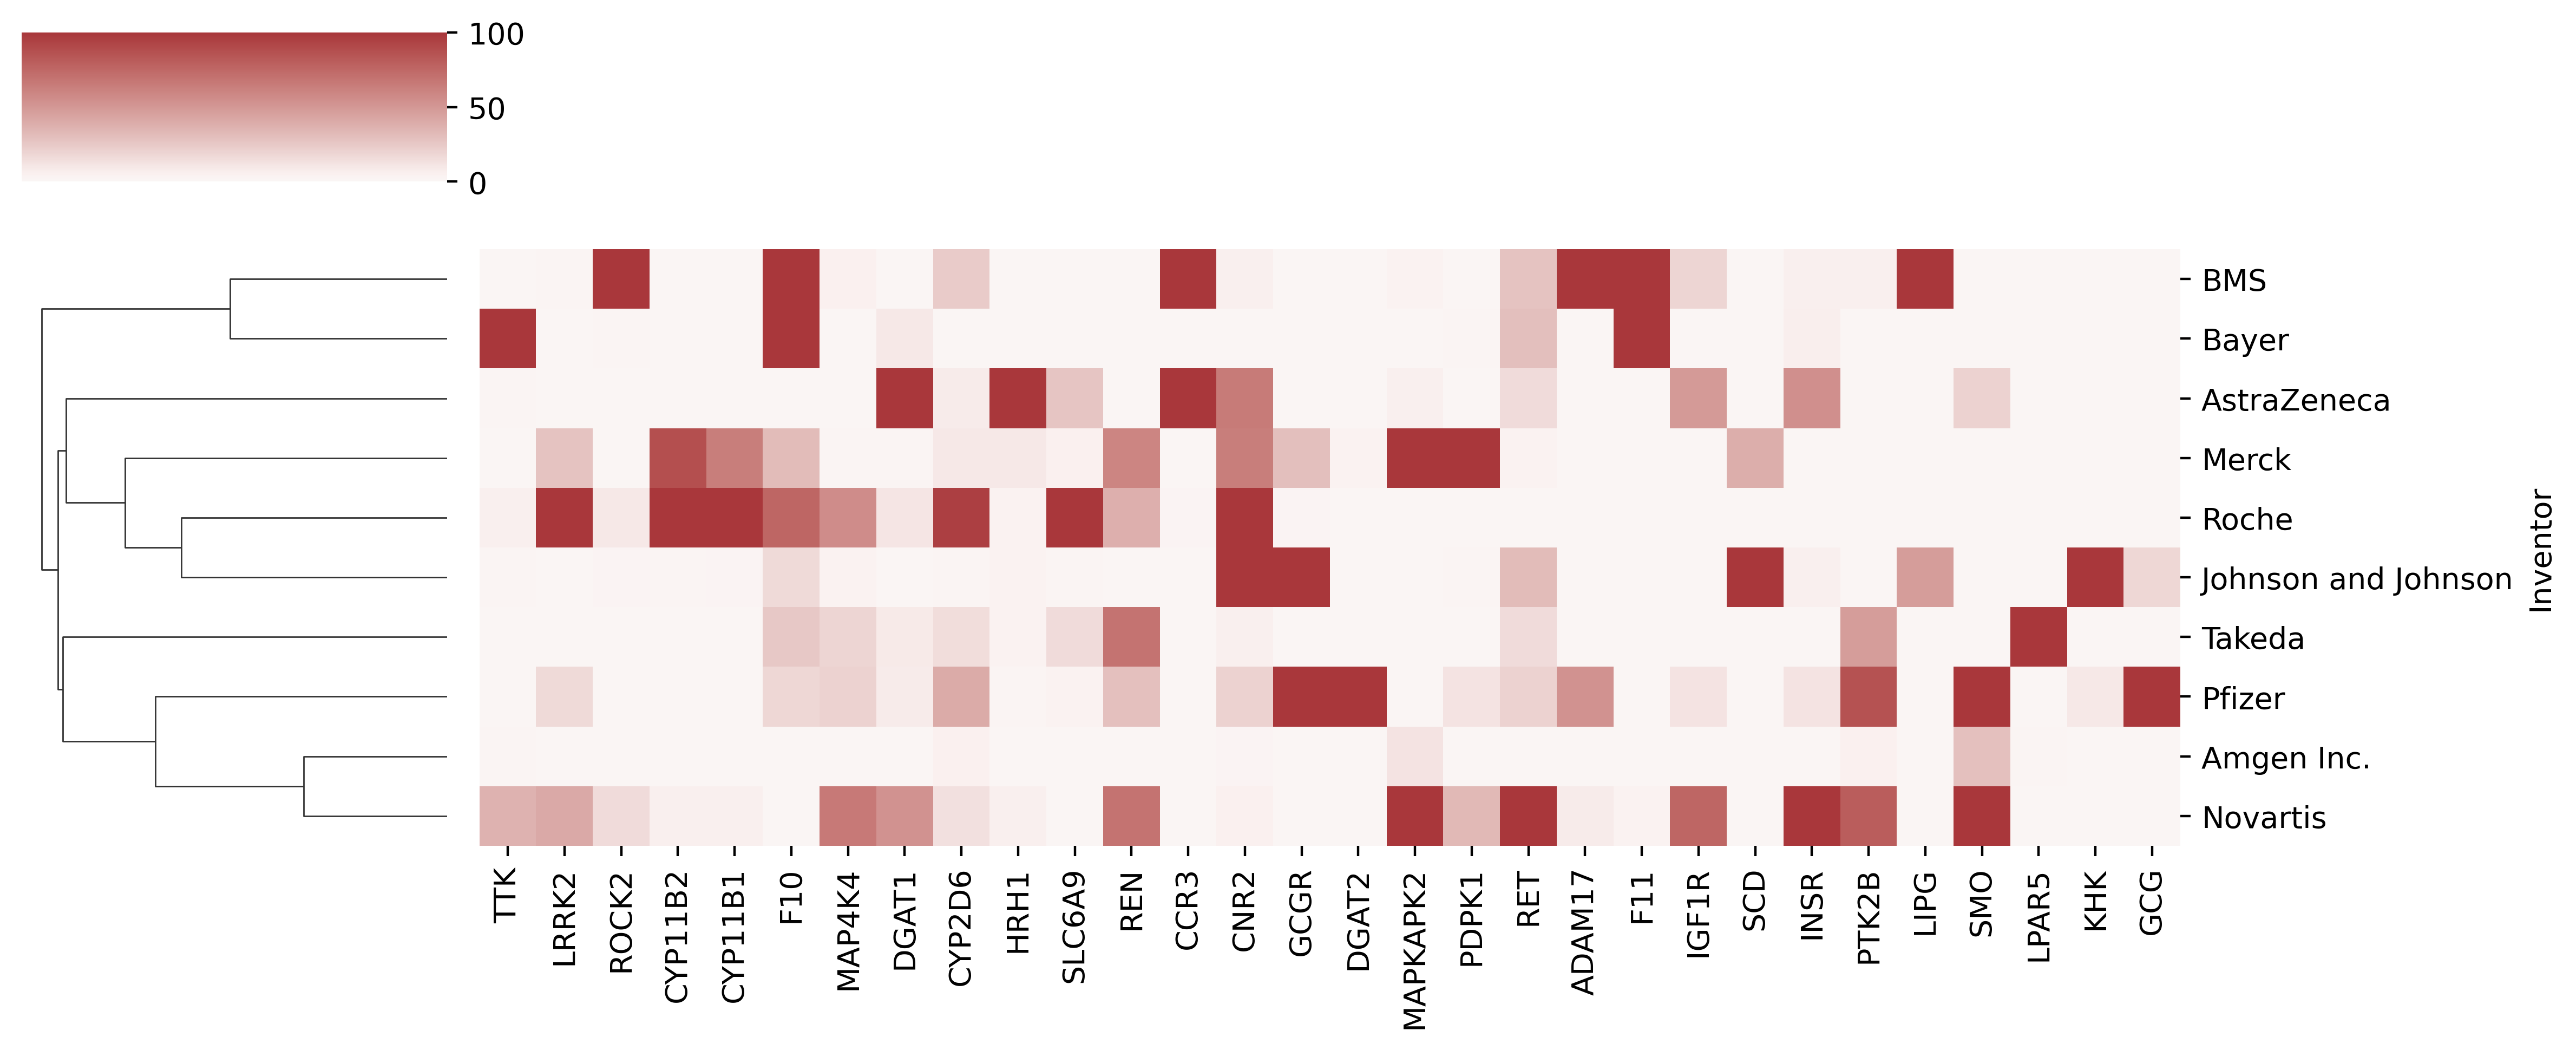

In [20]:
sns.clustermap(
    alzheimer_disease_portfolio, 
    col_cluster=False,
    figsize=(12, 5),
    metric="correlation",
    vmin=0, vmax=100, 
    center=0,
    cmap='vlag'
)
plt.tight_layout()
plt.savefig(
    f'{FIG_DIR}/figure_8.png',
    dpi=400,
    bbox_inches='tight', 
)
plt.show()